# **College Student Placement Factors Dataset** #

#### Credits to `SAHIL ISLAM007` for the dataset. ####

Source: https://www.kaggle.com/datasets/sahilislam007/college-student-placement-factors-dataset?resource=download


## Libraries ##

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import zscore, pearsonr
from matplotlib.colors import LinearSegmentedColormap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from factor_analyzer.factor_analyzer import calculate_kmo, FactorAnalyzer



import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Dataset ##

In [ ]:
path = r'Insert data path here'
data = pd.read_csv(path)

In [68]:
print(data.info())

#print(data.describe())

#print(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   College_ID              10000 non-null  object 
 1   IQ                      10000 non-null  int64  
 2   Prev_Sem_Result         10000 non-null  float64
 3   CGPA                    10000 non-null  float64
 4   Academic_Performance    10000 non-null  int64  
 5   Internship_Experience   10000 non-null  object 
 6   Extra_Curricular_Score  10000 non-null  int64  
 7   Communication_Skills    10000 non-null  int64  
 8   Projects_Completed      10000 non-null  int64  
 9   Placement               10000 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 781.4+ KB
None


### Known Fields ###
- **College_ID**
    - Unique ID of colleges.
- **IQ**
    - Student IQ score (normally distributed around 100.)
- **Prev_Sem_Result**
    -  Grade point average of previous semester (range of 5.0 to 10.0).
- **CGPA**
    - Cumulative Grde Point Average  (range of ~5.0 to 10.0)
- **Academic_Performance**
    - Scale (1 to 10) for annual academic rating.
- **Internship_Experience**
    - Boolean ('Yes'/'No') for student past internship experience.
- **Communication_Skills**
    - Scale (1 to 10) for communication ability rating.
- **Projects_Completed**
    - Count (0 to 5) of projects completed.
- **Placement**
    - Boolean ('Yes'/'No') of whether student got a placement.

## Objectives (Current) ##
- Clean/normalize/adjust dataset for data analysis if needed.
- Identify preliminary (linear) relationships between data using a correlation matrix with p-values for significance.
- Identify key factors and their importance that influence placement using factor analysis (or other) methods.
- Consider feature engineer a ``Student_Score`` using factors (and weightings if needed) for determining placement.
- Test ``Student_Score`` for suitability using a decision tree.
- If suitable, identify key thresholds that can be used for automating placement decisions using ``Student_Score``. Consider methods such as logistic regression or random forest.
- Train a model to categorise whether a student will get a placement or not. Consider ensemble learning methods for improved accuracy.
- Test the model for suitability.

## Cleaning Dataset ##

In [69]:
empty_columns = data.columns[data.isnull().any()].to_list()
print("Columns with empty values: ", empty_columns)

Columns with empty values:  []


In [70]:
dupes = data[data.duplicated()]
print("Duplicate values: ", dupes.shape[0])

Duplicate values:  0


#### Outlier Detection w/ z-Score ####
Outliers should only be possible in quantitative fields.

In [71]:
 #Possible fields: 'IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 'Communication_Skills', 'Projects_Completed'

#Parameters
outlier_std = 3         #Default is 3.
quantitative_fields = ['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 'Communication_Skills', 'Projects_Completed']


#### Note: ####
Function `find_outliers` will re-define z-scores when called. <br>
Therefore updating the dataset AND calling the function after, can cause new outliers to re-emerge based on updated dataset.

In [72]:
#Return relevant outlier values.
def find_outliers(param_field):
    data_z = pd.DataFrame(zscore(data[param_field], nan_policy='omit'), columns=[param_field], index=data.index)
    outlier_mask = (abs(data_z) > outlier_std).any(axis=1)
    outliers = data[outlier_mask]
    
    return outlier_mask, outliers
    
mask, outliers = find_outliers(quantitative_fields)

print(outliers)

     College_ID   IQ  Prev_Sem_Result  CGPA  Academic_Performance  \
209     CLG0073  157             8.33  8.53                     4   
262     CLG0004   51             7.26  7.43                     1   
478     CLG0047  146             9.72  9.44                     8   
1615    CLG0037  147             8.34  7.90                     6   
1957    CLG0037  147             7.58  7.14                     4   
2024    CLG0044   54             9.04  8.82                     4   
2305    CLG0047  146             5.81  5.37                     8   
2895    CLG0056  158             6.07  5.89                     8   
3716    CLG0033  148             9.37  9.08                     1   
3982    CLG0037  147             5.15  5.32                     9   
4198    CLG0071   54             9.07  9.27                     7   
4725    CLG0017   52             8.92  9.36                     8   
4779    CLG0057   52             7.56  7.36                     9   
4870    CLG0100  146             9

In [73]:
#Determine which columns have outliers above the specified standard deviation, and how many.
for field in quantitative_fields:
    _ , outliers = find_outliers(field)
    print(f"Number of outliers in {field}: {outliers.shape[0]}")

Number of outliers in IQ: 28
Number of outliers in Prev_Sem_Result: 0
Number of outliers in CGPA: 0
Number of outliers in Academic_Performance: 0
Number of outliers in Communication_Skills: 0
Number of outliers in Projects_Completed: 0


#### Replace Outliers ####

In [74]:
IQ_median = data['IQ'].median()
print("Median of IQ: ", IQ_median, '\n')

IQ_outlier_mask, _ = find_outliers(['IQ'])
IQ_outlier_indices = data[IQ_outlier_mask].index.tolist()

#Replace outliers of IQ values with median.
data.loc[IQ_outlier_mask, 'IQ'] = IQ_median

#Check that the outlier values have been replaced with median (99 in this case), using indexes from mask.
print("Replaced values:\n", data.loc[IQ_outlier_indices, 'IQ'])


Median of IQ:  99.0 

Replaced values:
 209     99
262     99
478     99
1615    99
1957    99
2024    99
2305    99
2895    99
3716    99
3982    99
4198    99
4725    99
4779    99
4870    99
4997    99
5796    99
6891    99
7140    99
7223    99
7305    99
7611    99
7677    99
8024    99
8180    99
8200    99
8248    99
8726    99
9770    99
Name: IQ, dtype: int64


#### Convert Boolean to Binary ####
Cast Yes/No values to 1/0. <br>
Initial data type is object so it needs to be cast into a string.

In [75]:
data['Internship_Experience'] = data['Internship_Experience'].astype(str)
data['Placement'] = data['Placement'].astype(str)

data['Internship_Experience'] = data['Internship_Experience'].map({'No' : 0, 'Yes' : 1})
data['Placement'] = data['Placement'].map({'No' : 0, 'Yes' : 1})

#print(data['Internship_Experience'])
#print(data['Placement'])

## Correlation Matrix ##
Checking linear relationships between numerical data.

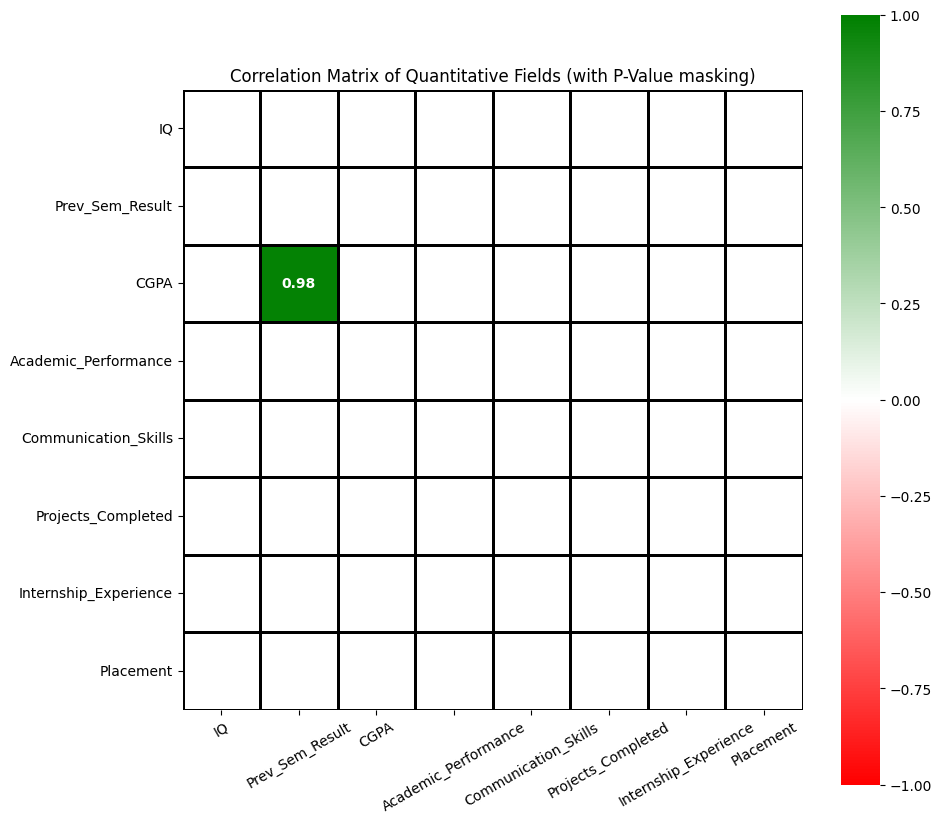

In [76]:
#Base parameters
quantitative_fields = ['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 'Communication_Skills', 'Projects_Completed', 'Internship_Experience', 'Placement'] #Append new binary values.
corr_data = data[quantitative_fields].corr()
p_value_corr = round(corr_data.corr(method=lambda x, y : pearsonr(x, y)[1]), 4)
p_value = 0.05 #Default p-value for significance = 0.05

#Figure parameters
mask = np.triu(corr_data)
p_mask = np.invert(np.tril(p_value_corr < p_value))
gradient = LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
x, fig = plt.subplots(figsize=(10,10))

#Switch mask between p_value filtering depending on preference.
sns.heatmap(corr_data, mask=p_mask, cmap=gradient, vmin=-1, vmax=1, linewidths=2, linecolor='black', annot=True, annot_kws={'fontweight' : 'bold'}, square=True)
plt.title('Correlation Matrix of Quantitative Fields (with P-Value masking)')
plt.xticks(rotation=30)
plt.show()

## Student Score ##
**Defined As**: A measure used to determine the likelihood a student will receive a placement based on their features/parameters. 
<br>
</br>
**Things to Consider**: 
- Identify features relevant to creating the ```Student Score```.
- Weighting of said features.
- Create a formula based on the above two points.
- Identifying a threshold for rejecting a student based on their score.
- Potentially adjust threshold based on the college, as different colleges may have different criterias.

### Factor Analysis ###
Based on correlation matrix, FA is unlikely to produce outstanding results. However, it is worth checking incase. <br>
**KMO Scores** will be used to test suitability of FA based on features.

In [77]:
#Parameters
fa_features = ['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 'Communication_Skills', 'Projects_Completed', 'Internship_Experience'] #Placement removed since Student_Score is used to determine this.
kmo_model = calculate_kmo(data[fa_features])
kmo_threshold = 0.5 #Minimum acceptable value for factor analysis (default is 0.5). Increase accordingly for better robustness.


#Is the KMO value in an acceptable range?
def kmo_result(param_index):
    if(kmo_model[0][param_index] > kmo_threshold):
        return 'Accept'
    else:
        return 'Reject'


#Check KMO score of each feature.
for x, feature in enumerate(fa_features):
    print(f'[{feature}] KMO Score: {kmo_model[0][x]:.4f} - Result: {kmo_result(x)}')

[IQ] KMO Score: 0.5011 - Result: Accept
[Prev_Sem_Result] KMO Score: 0.5001 - Result: Accept
[CGPA] KMO Score: 0.5001 - Result: Accept
[Academic_Performance] KMO Score: 0.4486 - Result: Reject
[Communication_Skills] KMO Score: 0.6162 - Result: Accept
[Projects_Completed] KMO Score: 0.6067 - Result: Accept
[Internship_Experience] KMO Score: 0.5661 - Result: Accept


#### Breakdown of Results: ####
Excluding ```Academic_Performance```, all other features were in **acceptable** range. <br>
*However*, asides from  ```Communication_Skills``` & ```Projects_Completed``` (which were classified as mediocore), all other values were **miserable** (0.5 - 0.6 range). <br>
Consider trying an alternative method such as **PCA** or **Decision Tree**. <br>

#### Eigen Values ####
Further testing for Factor Analysis suitability.

Eigenvalues: 
Factor 0: 1.9826
Factor 1: 1.0473
Factor 2: 1.0229
Factor 3: 0.9827
Factor 4: 0.9748
Factor 5: 0.9706
Factor 6: 0.0192


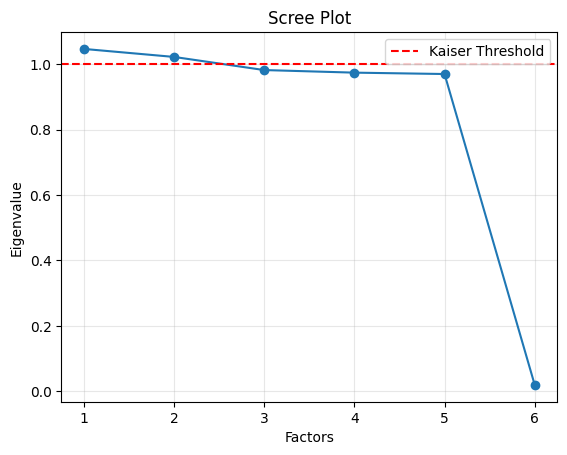

In [78]:
fa_model = FactorAnalyzer(rotation='varimax')
fa_model.fit(data[fa_features])

eigen_values, v = fa_model.get_eigenvalues()
kaiser_threshold = 1 #Accept variables with eigen values above this. Default is 1.

print('Eigenvalues: ')

for x in range(len(eigen_values)):
    print(f'Factor {x}: {eigen_values[x]:.4f}')

plt.plot(range(1, len(eigen_values)), eigen_values[1:], marker='o')
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')

plt.grid(True, alpha=0.3)
plt.axhline(y=kaiser_threshold, color='red', linestyle='--', label='Kaiser Threshold')
plt.legend()

plt.show()

#### Breakdown of Results: ####
Only **2** factors are above kaiser criterion.
- Suggests weak factor structure.
- Not very suitable for Factor Analysis, previous KMO score also supports this idea.
- Consider alternatives.

### Conlusion for Factor Analysis ###
- KMO & eigenvalues indicate that the presented data is *not very suitable* for factor analysis.
- ```Communication_Skills``` & ```Projects_Completed``` have higher suitability than other features based on KMO. 
    - Consider greater weightings when feature engineering.
- ```Academic_Performance``` has terrible KMO. 
    - Consider dropping the feature from formula.
- **Next steps**:
    - Try using PCA for dimensionality reduction & weightings.
    - Combine PCA findings with decision tree for a more robust data driven formula.
    - Use ```Placement``` with random forest or decision tree to validate the formula.
    - Consider logistic regression or decisionn trees to calibrate the score, and determine a key threshold.

### PCA for Dimensionality Reduction & Weightings ###

Identify n_components for PCA.

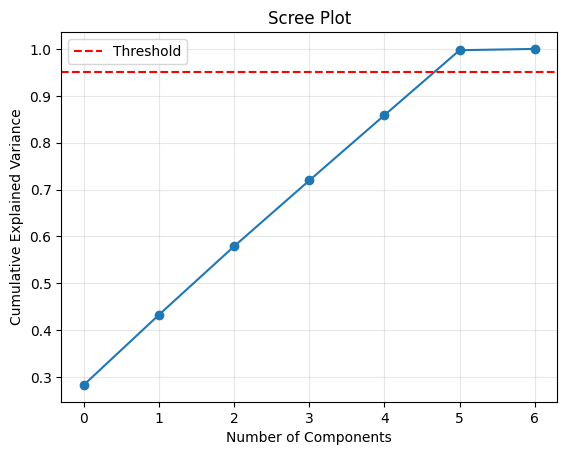

In [79]:
#Scale the data for better accuracy for observations during PCA.
std_scaler = StandardScaler()
cev_threshold = 0.95 #Accept number of components that exceed the threshold of cumulative explained variance. Default value is 0.95.



def scale_data(param_scaler, param_features):
    return param_scaler.fit_transform(data[param_features])



def pca_component_plot(param_scaler, param_features, param_threshold):
    PCA_data_scaled = scale_data(param_scaler, param_features)

    pca_model = PCA()
    pca_model.fit(PCA_data_scaled)

    plt.plot(np.cumsum(pca_model.explained_variance_ratio_), marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Scree Plot')

    plt.grid(True, alpha=0.3)
    plt.axhline(y=param_threshold, color='red', linestyle='--', label='Threshold')
    plt.legend()
    plt.show()



pca_component_plot(std_scaler, fa_features, cev_threshold)

**Accept n_component as 5.**

In [80]:
def pca_weightings(param_scaler, param_features, param_components):
    PCA_data_scaled = scale_data(param_scaler, param_features)

    pca_model = PCA(n_components=param_components)
    pca_model.fit_transform(PCA_data_scaled)
    offset = 1

    for x, pc in enumerate(pca_model.components_):
        print(f'Principal Component {x + offset}:')

        for pcx, feature in enumerate(pc):
            print(f'{param_features[pcx]}: {feature:.4f}')

        print('\n')



pca_weightings(std_scaler, fa_features, 5)

Principal Component 1:
IQ: -0.0005
Prev_Sem_Result: 0.7064
CGPA: 0.7065
Academic_Performance: -0.0066
Communication_Skills: -0.0251
Projects_Completed: 0.0286
Internship_Experience: -0.0186


Principal Component 2:
IQ: -0.0909
Prev_Sem_Result: 0.0069
CGPA: 0.0088
Academic_Performance: 0.6037
Communication_Skills: -0.4598
Projects_Completed: -0.2754
Internship_Experience: 0.5830


Principal Component 3:
IQ: 0.6822
Prev_Sem_Result: -0.0191
CGPA: -0.0174
Academic_Performance: -0.0869
Communication_Skills: -0.4563
Projects_Completed: 0.5553
Internship_Experience: 0.0993


Principal Component 4:
IQ: -0.6072
Prev_Sem_Result: -0.0186
CGPA: -0.0161
Academic_Performance: 0.2839
Communication_Skills: -0.1158
Projects_Completed: 0.7191
Internship_Experience: -0.1399


Principal Component 5:
IQ: 0.0327
Prev_Sem_Result: 0.0133
CGPA: 0.0138
Academic_Performance: -0.1028
Communication_Skills: 0.6004
Projects_Completed: 0.3075
Internship_Experience: 0.7300




Where Principle Component 1 explains the most data variance, with higher indexes being less robust.
- Prioritise PC1 findings.
- PC2 & PC3 has less importance than PC1, but still contains highly revelant information.
- PC4 & PC5 should be used as supplementary information rather than facts.
- PCA (Weightings) > KMO score (Feature suitability).
- Strong contributions in **multiple** PC means greater robustness of the feature, in the context of ```Student_Score``` structure.
- Strong PC1 > Multiple Strong PCs (PC1 is more structural dominant - Narrow but strong influence > Broad but weak).

#### Breakdown of Results: ####
- ```CGPA``` + ```Prev_Sem_Result```: have the greatest contribution in PC1 (most important component).
    - Consider giving greatest weighting.
- ```Internship_Experience``` + ```Academic_Performance```: have the greatest contribution in PC2.
    - ```Academic_Performance``` had poor KMO, and had high contributions in *ONLY* PC2 which should be factored in.
    - ```Internship_Experience``` had the highest loading in PC5.
- ```Projects_Completed``` + ```IQ```: have the greatest contribution in PC3.
    - ```Projects_Completed``` had a *high* KMO value, and is has high contribution in PC4.
    - ```IQ``` has poor contribution in all other PCs.
- ```Communication_Skills```.
    - Has *high* KMO value.
    - Only strong contribution is in PC5.

#### Strong Features: ####
- ```CGPA``` - Excellent PC1 & strongly correlated with ```Prev_Sem_Result``` - **Core feature**.
- ```Prev_Sem_Result``` - Excellent PC1 & strongly correlated with ```CGPA``` - **Core feature**.
- ```Internship_Experience``` - Strong in PC2 & PC5.
- ```Projects_Completed``` - Strong in PC3 & PC4.

#### Weak Features (Consider dropping): ####
- ```Academic_Performance``` - Only strong in PC2, and the only feature to be rejected by KMO score.
- ```IQ``` - Only strong in PC3.
- ```Communication_Skills``` - Neglible contribution in all but PC5, the weakest PC.

### Re-Run PCA (Dimensionality Reduction) ###
Determining what features to drop by running PCA without x weak feature.

Without ```Communication_Skills```.

['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 'Projects_Completed', 'Internship_Experience']


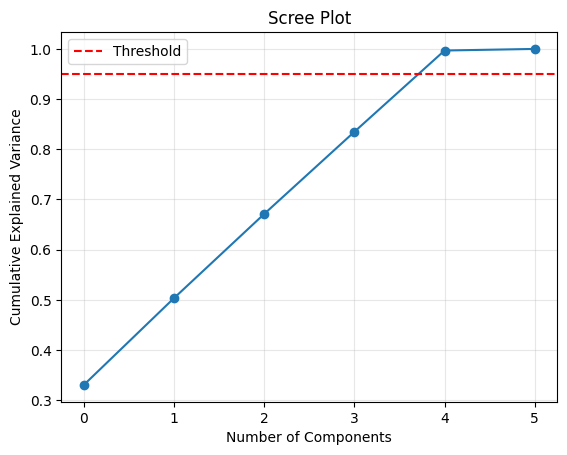

In [81]:
features_dr_communication = fa_features.copy()
features_dr_communication.remove('Communication_Skills')
print(features_dr_communication)

pca_component_plot(std_scaler, features_dr_communication, cev_threshold)

In [82]:
pca_weightings(std_scaler, features_dr_communication, 4)

Principal Component 1:
IQ: -0.0008
Prev_Sem_Result: 0.7067
CGPA: 0.7067
Academic_Performance: -0.0072
Projects_Completed: 0.0286
Internship_Experience: -0.0191


Principal Component 2:
IQ: -0.3517
Prev_Sem_Result: 0.0193
CGPA: 0.0202
Academic_Performance: 0.6064
Projects_Completed: -0.4828
Internship_Experience: 0.5241


Principal Component 3:
IQ: 0.6977
Prev_Sem_Result: -0.0004
CGPA: 0.0018
Academic_Performance: 0.2723
Projects_Completed: 0.4040
Internship_Experience: 0.5252


Principal Component 4:
IQ: -0.5470
Prev_Sem_Result: -0.0161
CGPA: -0.0133
Academic_Performance: 0.3266
Projects_Completed: 0.7697
Internship_Experience: -0.0347




#### Breakdown of Results: ####
- n_components dropped to 4.
    - Model needs less components to explain the same degree of variance. 
    - An obvious sign of a cleaner & robust structure.
    - Suggests that ```Communication_Skills``` introduced noise into the structure or was redundant.
- Loadings have increased across the features & components.
    - ```CGPA``` & ```Prev_Sem_Result``` remain strong in PC1, reinforncing the fact that they are suitable core features.

**Therefore drop ```Communication_Skills```**.

Without ```Academic_Performance```.

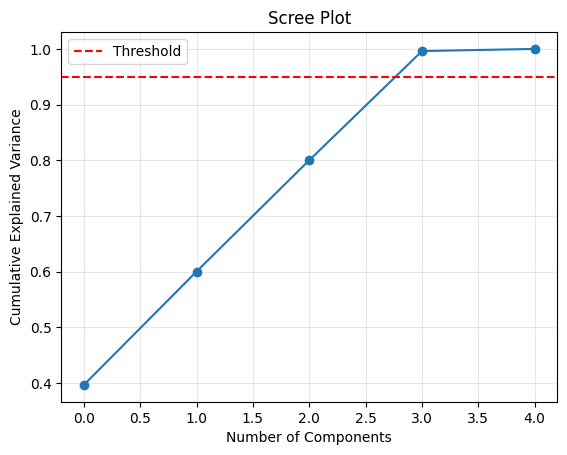

In [83]:
features_dr_academic = features_dr_communication.copy()
features_dr_academic.remove('Academic_Performance')
#print(features_dr_academic)

pca_component_plot(std_scaler, features_dr_academic, cev_threshold)

In [84]:
pca_weightings(std_scaler, features_dr_academic, 3)

Principal Component 1:
IQ: -0.0009
Prev_Sem_Result: 0.7067
CGPA: 0.7067
Projects_Completed: 0.0285
Internship_Experience: -0.0189


Principal Component 2:
IQ: 0.6191
Prev_Sem_Result: -0.0192
CGPA: -0.0177
Projects_Completed: 0.7049
Internship_Experience: -0.3452


Principal Component 3:
IQ: 0.5069
Prev_Sem_Result: 0.0120
CGPA: 0.0127
Projects_Completed: -0.0227
Internship_Experience: 0.8615




#### Breakdown of Results: ####
- Components dropped from **4** to **3**.
    - Similar case to ```Communication_Skills``` - Less complexity needed to explain the same variance when removed.
    - ```Academic_Performance``` either introduced noise, or can be explained by other features (e.g. ```Prev_Sem_Results``` and/or ```CGPA```), making it redundant to the structure.
- Better clarity for other component loadings.
    - ```CGPA``` & ```Prev_Sem_Results``` remain dominant in PC1.
    - ```IQ``` now has a strong contribution in PC2 (alongside ```Projects_Completed```) with retained moderate contribution in PC3 (alongside ```Internship_Experience```).
- Additionally showed poor KMO score previously.

**Therefore drop ```Academic_Performance```**.

Without ```IQ```.

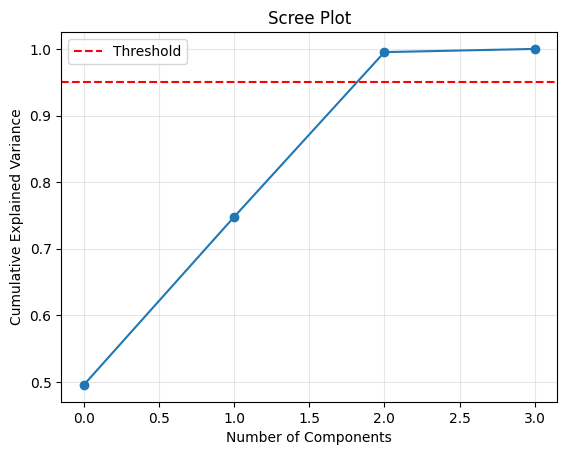

In [85]:
feature_dr_iq = features_dr_academic.copy()
feature_dr_iq.remove('IQ')
#print(feature_dr_iq)

pca_component_plot(std_scaler, feature_dr_iq, cev_threshold)

In [86]:
pca_weightings(std_scaler, feature_dr_iq, 2)

Principal Component 1:
Prev_Sem_Result: 0.7067
CGPA: 0.7067
Projects_Completed: 0.0285
Internship_Experience: -0.0189


Principal Component 2:
Prev_Sem_Result: 0.0242
CGPA: 0.0231
Projects_Completed: -0.6986
Internship_Experience: 0.7148




#### Breakdown of Results: ####
- Components reduced from **3** to **2**.
    - ```IQ``` has a similar issue to the previous two features of either introducing noise, or being explained by other features.
    - However, variance may not be captured by remaining feature - not necessarily noise, and can still be meaningful.
- Clarity of component weightings has decreased when removed.
    - ```Internship_Experience``` pairs with nothing in PC2 - **Isolated**.
    - ```Projects_Completed``` has weak contribution in both PC1 or PC2, leading to the issue of also being removed from the structure.

Considerations:
- Statistical Optimization != Practical Usefulness
    - Reducing too many features may reduce predictive power, which is counter-intuitive to the original intent of creating a ```Student_Score```.
    - PCA is designed to compress variance not predict an outcome, therefore not an absolute indicator.
- ```IQ``` somewhat pairs well with both ```Projects_Completed``` & ```Internship_Experience```.
    - Both features are objective indicators, compared to ```Academic_Performance``` & ```Communication_Skills``` which can be subjective (and objective).
- Removing ```IQ``` will likely lead to removing ```Projects_Completed```, which can also potentially lead to removing ```Internship_Experience```.
    - These features represent non-academic capability.
    - Placements are unlikely to be decided by academic metrics alone in a real-world scenario.

**Therefore keep ```IQ``` for now; as it maintains structural integrity of non-academic elements. Re-evaluate if prompted in future tests**.

### RandomForest ###

Determine the split between placement totals (Yes/No) for standardized data sample, in the event of class imbalance.

In [87]:
count_placements = data.loc[data['Placement'] == 1, 'Placement'].count()
print(f'{count_placements} placements out of {data.shape[0]}')

1659 placements out of 10000


#### Stratisfied Sampling ####
Ensuring that an equal split is present in the sample so that data accuracy is not greatly affected.

In [88]:
placement_yes = data[data['Placement'] == 1]
placement_no = data[data['Placement'] == 0]

#Take a sample using the maximum amount of the smallest group, from the largest group.
placement_no_resampled = resample(placement_no, replace=False, n_samples=count_placements, random_state=1)
#print(placement_no_resampled.count())

#Combine both samples.
placement_resampled = pd.concat([placement_yes, placement_no_resampled])
#print(placement_resampled.loc[placement_resampled['Placement'] == 1, 'Placement'].count())

#Shuffle the data to remove possible bias when handling.
placement_resampled = placement_resampled.sample(frac=1, random_state=1).reset_index(drop=True)

#### Creating a Training and Test Set ####

In [89]:
placement_features = features_dr_academic.copy()
#print(placement_features)

placement_x = placement_resampled[placement_features]
placement_y = placement_resampled['Placement']

x_train, x_test, y_train, y_test = train_test_split(placement_x, placement_y, test_size=0.25, random_state=1)

#### Creating the RandomForest Model ####

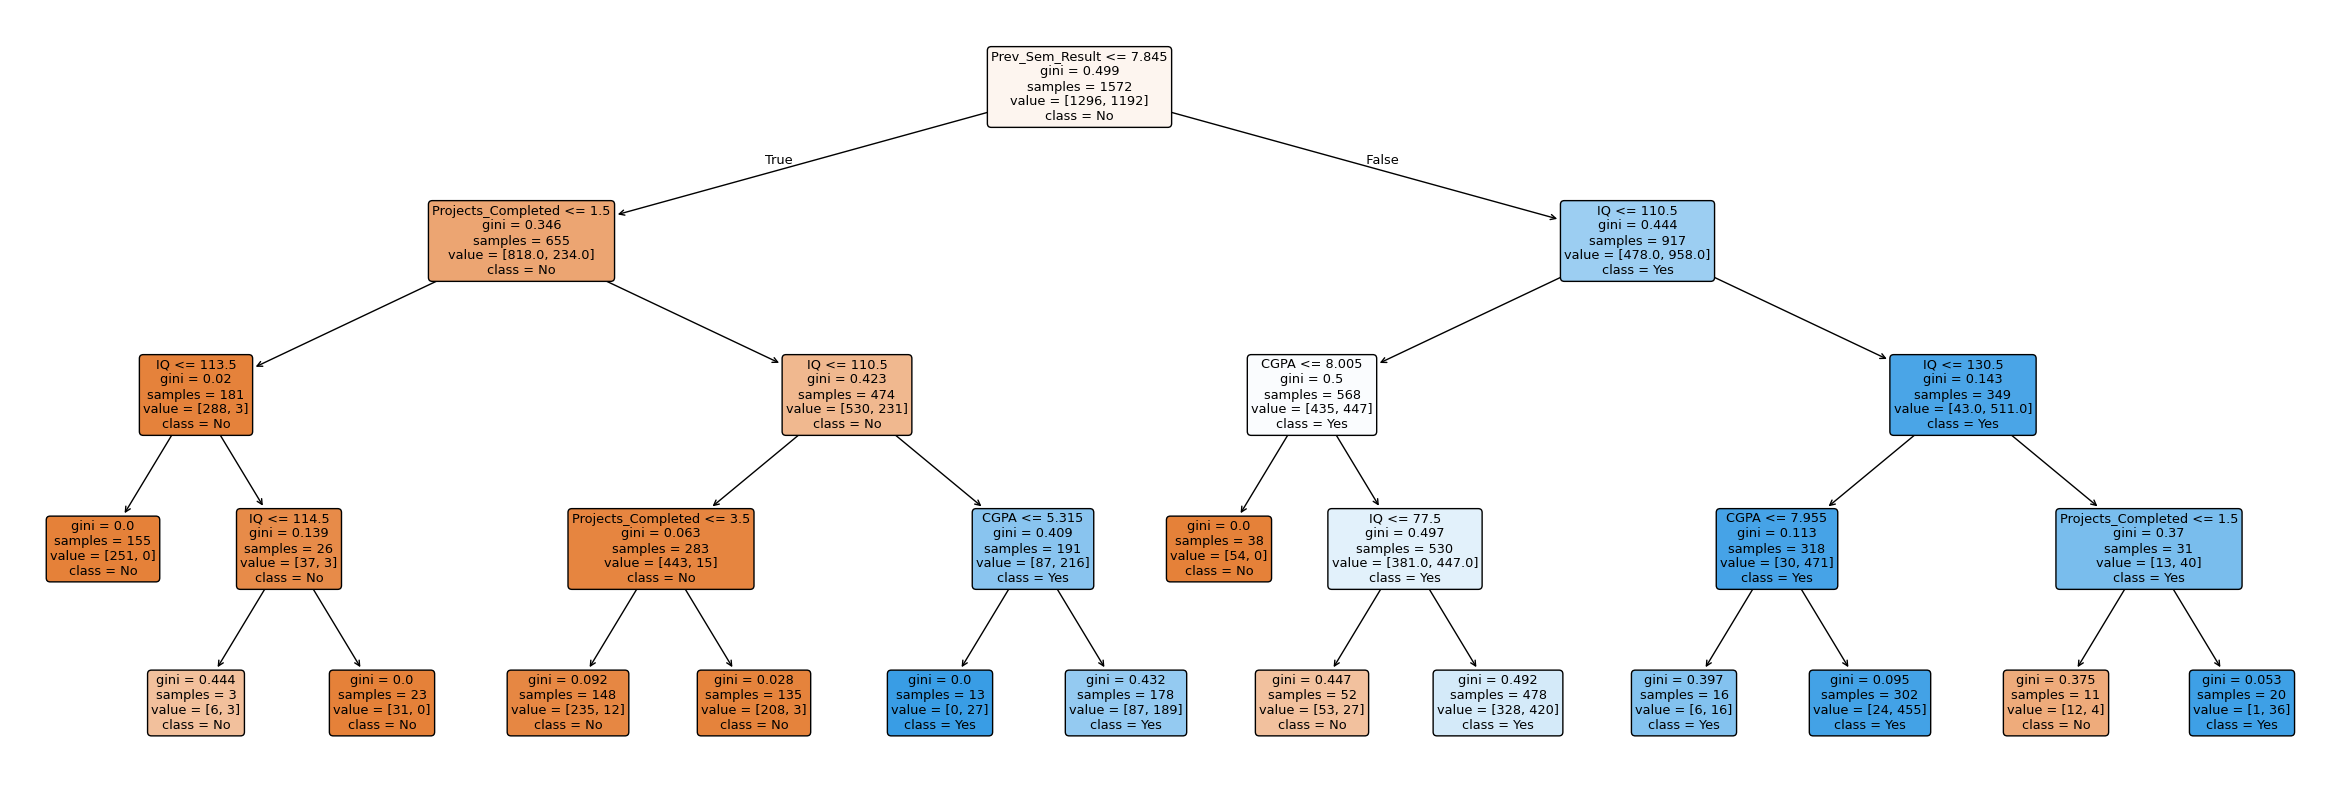

In [90]:
forest_model = RandomForestClassifier(random_state=1, max_depth=4)
forest_model.fit(x_train, y_train)

y_predict = forest_model.predict(x_test)

estimator = forest_model.estimators_[0]

plt.figure(figsize=(30,10))
plot_tree(estimator, feature_names=placement_x.columns, class_names=['No', 'Yes'], filled=True, rounded=True)
plt.show()

#print(forest_model.feature_importances_) #['IQ', 'Prev_Sem_Result', 'CGPA', 'Projects_Completed', 'Internship_Experience']

#### Validating the Model ####

**Accuracy Score Method**

In [91]:
forest_accuracy = accuracy_score(y_test, y_predict)
print(f'Accuracy Score: {forest_accuracy:.4f}')

Accuracy Score: 0.8627


**F1 Score Method**

In [92]:
forest_f1 = f1_score(y_test, y_predict, average=None)
print(f'F1 Score Placement (No): {forest_f1[0]:.4f}')
print(f'F1 Score Placement (Yes): {forest_f1[1]:.4f}')

F1 Score Placement (No): 0.8376
F1 Score Placement (Yes): 0.8810


**Confusion Matrix**

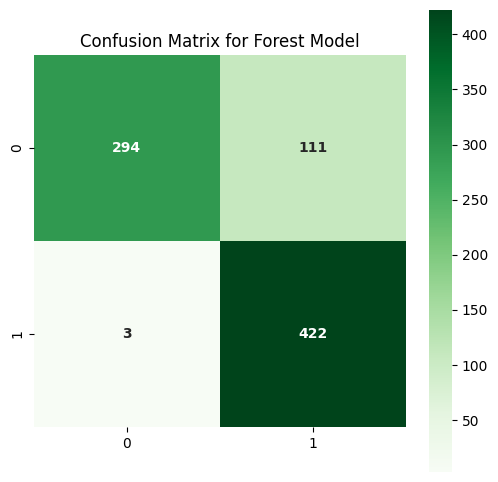

In [94]:
forest_confusion = confusion_matrix(y_test, y_predict)
#print(confusion_matrix(y_test, y_predict))

plt.figure(figsize=(6,6))
sns.heatmap(forest_confusion, cmap='Greens', square=True, annot=True, annot_kws={'fontweight' : 'bold'}, fmt='g')
plt.title('Confusion Matrix for Forest Model')
plt.show()